---
title: Stat analysis
description: dzad
kernelspec:
  name: TER
mystnb:
    execution_mode: 'cache'
---

### Imports

In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import display, Markdown, HTML
from datetime import datetime

sns.set_theme(style = 'ticks', palette = 'pastel')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.bbox'] = 'tight'
sns.set_context("paper")
# Define fig saving context
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.directory'] = 'figures'

### Loading data

In [24]:
match_results = pd.read_csv('data/match_results2.csv', parse_dates=['date'])
match_results.shape

(10921, 5)

In [25]:
match_results['win'] = match_results['result'].apply(lambda x: 1 if x == 'win' else 0)
match_results['loss'] = match_results['result'].apply(lambda x: 1 if x == 'loss' else 0)
match_results['draw'] = match_results['result'].apply(lambda x: 1 if x == 'draw' else 0)

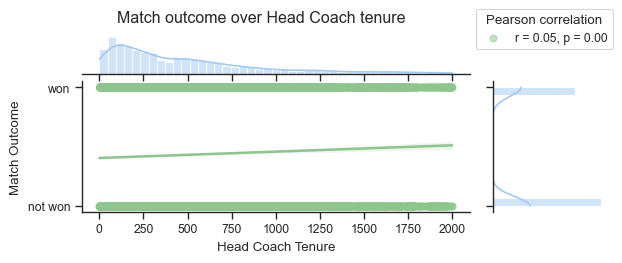

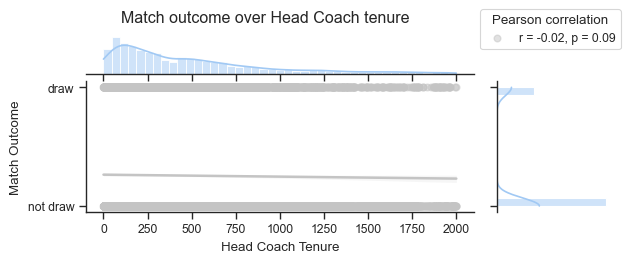

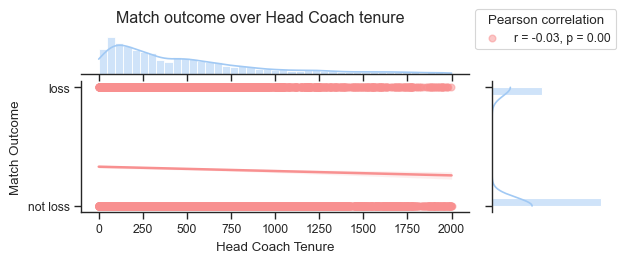

In [26]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def plot_match_outcome_over_coach_tenure(data, y_value, y_label, color):
    # Create a jointplot
    # g = sns.jointplot(data=data, x='days_in_post', y=y_value, kind='reg', ratio = 3, marginal_ticks = False)
    g = sns.jointplot(data=data, x='days_in_post', y=y_value, kind='reg', 
                      scatter_kws={'alpha':0.5, 'color': sns.light_palette(color, as_cmap=True)(0.4)}, 
                      line_kws={'color': sns.light_palette(color, as_cmap=True)(0.4)}, 
                      ratio = 3, marginal_ticks = False)
    g.figure.set_figwidth(6)
    g.figure.set_figheight(2)
    g.figure.suptitle(f'Match outcome over Head Coach tenure', x = 0.4, y = 1.1)
    g.set_axis_labels('Head Coach Tenure', 'Match Outcome')
    
    # Legend
    r, p = pearsonr(data['days_in_post'], data[y_value])
    legend = g.ax_joint.legend([f'r = {r:.2f}, p = {p:.2f}'], loc='upper left', bbox_to_anchor=(1, 1.6))
    legend.set_title("Pearson correlation")
    
    # Set y-axis tick
    g.ax_joint.set_yticks([0, 1])
    g.ax_joint.set_yticklabels(['not ' + y_label, y_label])
    # Save the figure
    g.savefig(f'figures/{y_value}_over_coach_tenure.png')

plot_match_outcome_over_coach_tenure(match_results, 'win', 'won', 'green')
plot_match_outcome_over_coach_tenure(match_results, 'draw', 'draw', 'gray')
plot_match_outcome_over_coach_tenure(match_results, 'loss', 'loss', 'red')

In [37]:
match_results_bis = match_results.groupby('days_in_post').agg({'win': 'mean', 'draw': 'mean', 'loss': 'mean', 'result': 'count'})
match_results_bis.columns = ['win_rate', 'draw_rate', 'loss_rate', 'match_count']
# Add missing days between the first and last day
match_results_bis = match_results_bis.reindex(range(match_results_bis.index.min(), match_results_bis.index.max() + 1), fill_value=0)

def weighted_rolling_mean(data, weights, window_size=30):
    def weighted_mean(x):
        return np.average(data.loc[x.index], weights=weights.loc[x.index])

    return data.rolling(window_size, min_periods=1).apply(weighted_mean, raw=False)

match_results_bis['win_rate_smooth'] = weighted_rolling_mean(match_results_bis['win_rate'], match_results_bis['match_count'])
match_results_bis['draw_rate_smooth'] = weighted_rolling_mean(match_results_bis['draw_rate'], match_results_bis['match_count'])
match_results_bis['loss_rate_smooth'] = weighted_rolling_mean(match_results_bis['loss_rate'], match_results_bis['match_count'])

# Ensures it sums to 1
(match_results_bis['win_rate_smooth'] + match_results_bis['draw_rate_smooth'] + match_results_bis['loss_rate_smooth']).value_counts()

1.0    1902
1.0      99
Name: count, dtype: int64

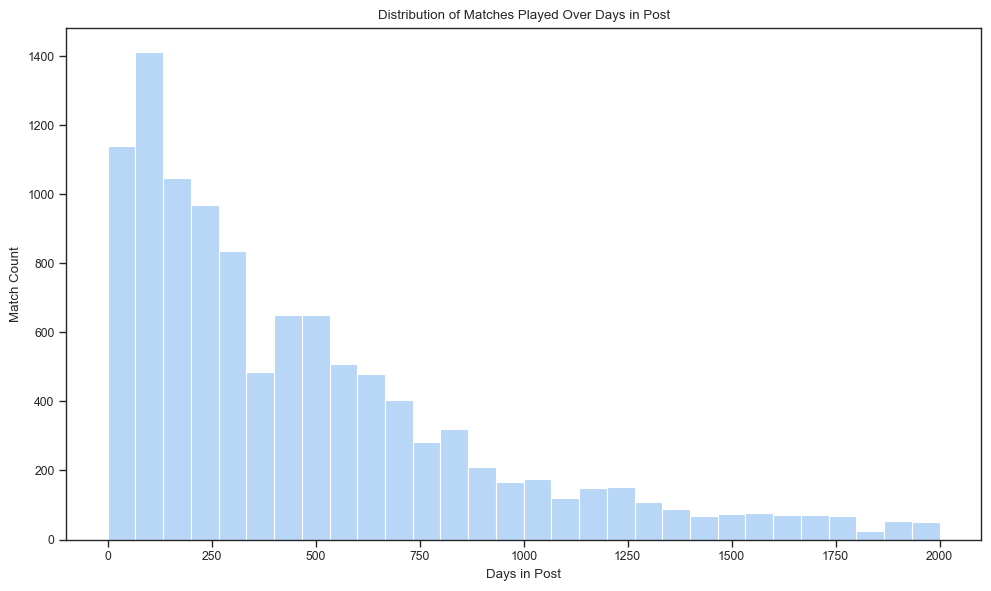

In [47]:
# Create a histogram of 'match_count' over 'days_in_post'
plt.figure(figsize=(10, 6))
sns.histplot(data=match_results_bis, x='days_in_post', weights='match_count', bins=30)
plt.xlabel('Days in Post')
plt.ylabel('Match Count')
plt.title('Distribution of Matches Played Over Head Coach Tenure')
plt.show()

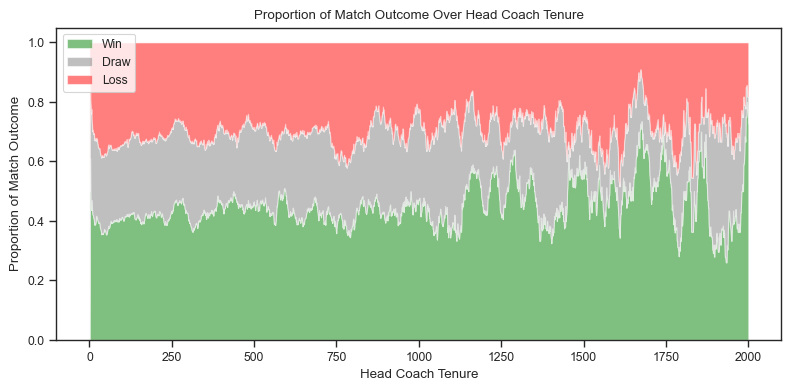

In [35]:
def plot_proportion_over_coach_tenure(data):
    # Create a figure
    plt.figure(figsize=(8, 4))

    plt.stackplot(data.index, data['win_rate_smooth'], data['draw_rate_smooth'], data['loss_rate_smooth'], labels=['Win', 'Draw', 'Loss'], colors=['green', 'gray', 'red'], alpha=0.5)

    # Add legend and labels
    plt.legend(loc='upper left')
    plt.xlabel('Head Coach Tenure')
    plt.ylabel('Proportion of Match Outcome')
    plt.title('Proportion of Match Outcome Over Head Coach Tenure (30-day weighted rolling average)')

    # Save the figure
    plt.savefig('figures/proportion_over_coach_tenure.png')
    plt.show()

plot_proportion_over_coach_tenure(match_results_bis)

## Correlation between days in post and teams performance

- could indicate that club keeps their well performing head-coaches
- could indicate that head coaches performance improve after time either because:
    - early low performance : coaches need some time once they are appointed to reach previous team performance
    - long term improvement of performance